# Составление словаря для оценки тональности текстов

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import json
import re

import bz2
from tqdm import tqdm
tqdm.pandas()

In [2]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:52, 3831.10it/s]


In [3]:
data = pd.DataFrame(responses)

data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [4]:
data = data[data["rating_grade"].isin([1, 5])]

## Предобработка данных

### Разбиение на предложения

In [5]:
from nltk.tokenize import sent_tokenize

In [6]:
full_texts = pd.DataFrame(columns=["index", "sentence_order", "sentence_text"])

for i, row in tqdm(data.iterrows()):
    text = row["text"]
    sentences = sent_tokenize(text)
    sentence_count = len(sentences)

    text_df = pd.DataFrame({
        "index": np.repeat(i, sentence_count),
        "sentence_order": np.arange(sentence_count),
        "sentence_text": sentences
    })

    full_texts = pd.concat([full_texts, text_df], axis=0)

62100it [20:59, 49.31it/s] 


### Лемматизация слов

In [7]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymorphy3 import MorphAnalyzer

In [8]:
rus_stopwords = stopwords.words("russian")

In [9]:
morph = MorphAnalyzer()


def get_lemmas(text: str, morph=morph):
    text = text.lower()
    cleaned_text = re.sub(f'[{punctuation}]', "", text)
    tokens = word_tokenize(cleaned_text)
    tokens = [token for token in tokens if token not in rus_stopwords]
    lemmas = [morph.normal_forms(token)[0] for token in tokens]

    return " ".join(lemmas)

In [10]:
full_texts["sentence_text"] = full_texts["sentence_text"].progress_apply(get_lemmas)

100%|██████████| 1197494/1197494 [09:03<00:00, 2204.35it/s]


### Обучение и тест модели Word2Vec

In [11]:
from gensim.models import Word2Vec

In [12]:
def get_tokens(text):
    return word_tokenize(text)


full_texts["tokens"] = full_texts["sentence_text"].apply(get_tokens)

In [13]:
model = Word2Vec(sentences=full_texts["tokens"], vector_size=100, window=5, min_count=1, workers=4)

In [14]:
model.init_sims()

C:\Users\Руслан\AppData\Local\Temp\ipykernel_19920\3100270657.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims()


In [15]:
model.save("my_word2vec_model.model")

#### Тест на поиск похожих слов

In [16]:
model.wv.most_similar("день") # Хороший пример

[('неделя', 0.7209892272949219),
 ('месяц', 0.7087016701698303),
 ('сутки', 0.6924532651901245),
 ('час', 0.5764643549919128),
 ('минута', 0.5705773234367371),
 ('вечер', 0.48651358485221863),
 ('мина', 0.46908092498779297),
 ('утро', 0.4652181565761566),
 ('понедельник', 0.4625767171382904),
 ('год', 0.46181049942970276)]

In [17]:
model.wv.most_similar("банк") # Хороший пример (хотя есть неоднозначность с последними словами)

[('сбербанк', 0.6840847134590149),
 ('ситибанк', 0.6732875108718872),
 ('альфабанка', 0.6326536536216736),
 ('росбанк', 0.6246004104614258),
 ('сбер', 0.5960267782211304),
 ('также', 0.582491934299469),
 ('компания', 0.5608768463134766),
 ('ваш', 0.5546275973320007),
 ('хотя', 0.552590548992157),
 ('который', 0.5507922768592834)]

In [18]:
model.wv.most_similar("инфляция") # Плохой пример

[('соотношение', 0.7042920589447021),
 ('коэффициент', 0.6538717746734619),
 ('подспорье', 0.6482155919075012),
 ('перевелось…', 0.6456987857818604),
 ('рентабельность', 0.6444392800331116),
 ('инвестирование', 0.6429957747459412),
 ('кормилец', 0.641840934753418),
 ('mosprime', 0.6418331861495972),
 ('уставкапитал', 0.635029137134552),
 ('дрожжи', 0.6335232257843018)]

In [19]:
model.wv.most_similar("договор") # Плохой пример

[('соглашение', 0.7345297932624817),
 ('контракт', 0.7293655276298523),
 ('допсоглашение', 0.7227081656455994),
 ('удбый', 0.6052708625793457),
 ('кд', 0.5998002886772156),
 ('077219717', 0.5827078223228455),
 ('250513г', 0.5528532266616821),
 ('полис', 0.5520756244659424),
 ('дмедведев', 0.5505146384239197),
 ('90550377', 0.5458100438117981)]

#### Тест на аналоги

In [20]:
# Пример аналогии
analogy = model.wv.most_similar(positive=['сбережение', 'кредит'], negative=['долг'], topn=5)

print(analogy)

[('накопление', 0.5913645029067993), ('мечта', 0.5114480257034302), ('кредитовать', 0.5098973512649536), ('ипотека', 0.5088470578193665), ('нужда', 0.5069460868835449)]


In [21]:
# Пример аналогии
analogy = model.wv.most_similar(positive=["банк", "финансовый"], negative=["учреждение"], topn=5)

print(analogy)

[('кредитный', 0.6046749949455261), ('банковский', 0.5537451505661011), ('также', 0.5281783938407898), ('ваш', 0.49628373980522156), ('негибкий', 0.4939434230327606)]


In [22]:
# Пример аналогии
analogy = model.wv.most_similar(positive=["сотрудник", "банк"], negative=["финансы"], topn=5)

print(analogy)

[('сотрудница', 0.5943720936775208), ('оператор', 0.5779834389686584), ('операционист', 0.5556332468986511), ('девушка', 0.5444627404212952), ('специалист', 0.5251325368881226)]


In [23]:
# Пример аналогии
analogy = model.wv.most_similar(positive=["клиент"], negative=["вклад"], topn=5)

print(analogy)

[('плательщик', 0.49186137318611145), ('httpwwwbankiruservicesresponsesbankid193284', 0.4590560793876648), ('халатный', 0.4455386698246002), ('должник', 0.4428364038467407), ('2014110333010054', 0.44094035029411316)]


#### Тест на поиск лишнего слова

In [24]:
model.wv.doesnt_match(["доллар", "рубль", "евро", "банк"]) # Хороший пример

'банк'

In [25]:
model.wv.doesnt_match(["долг", "кредит", "задолженность", "выплата"]) # Хороший пример

'выплата'

### Визуализации

#### Топ 100 слов

In [26]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

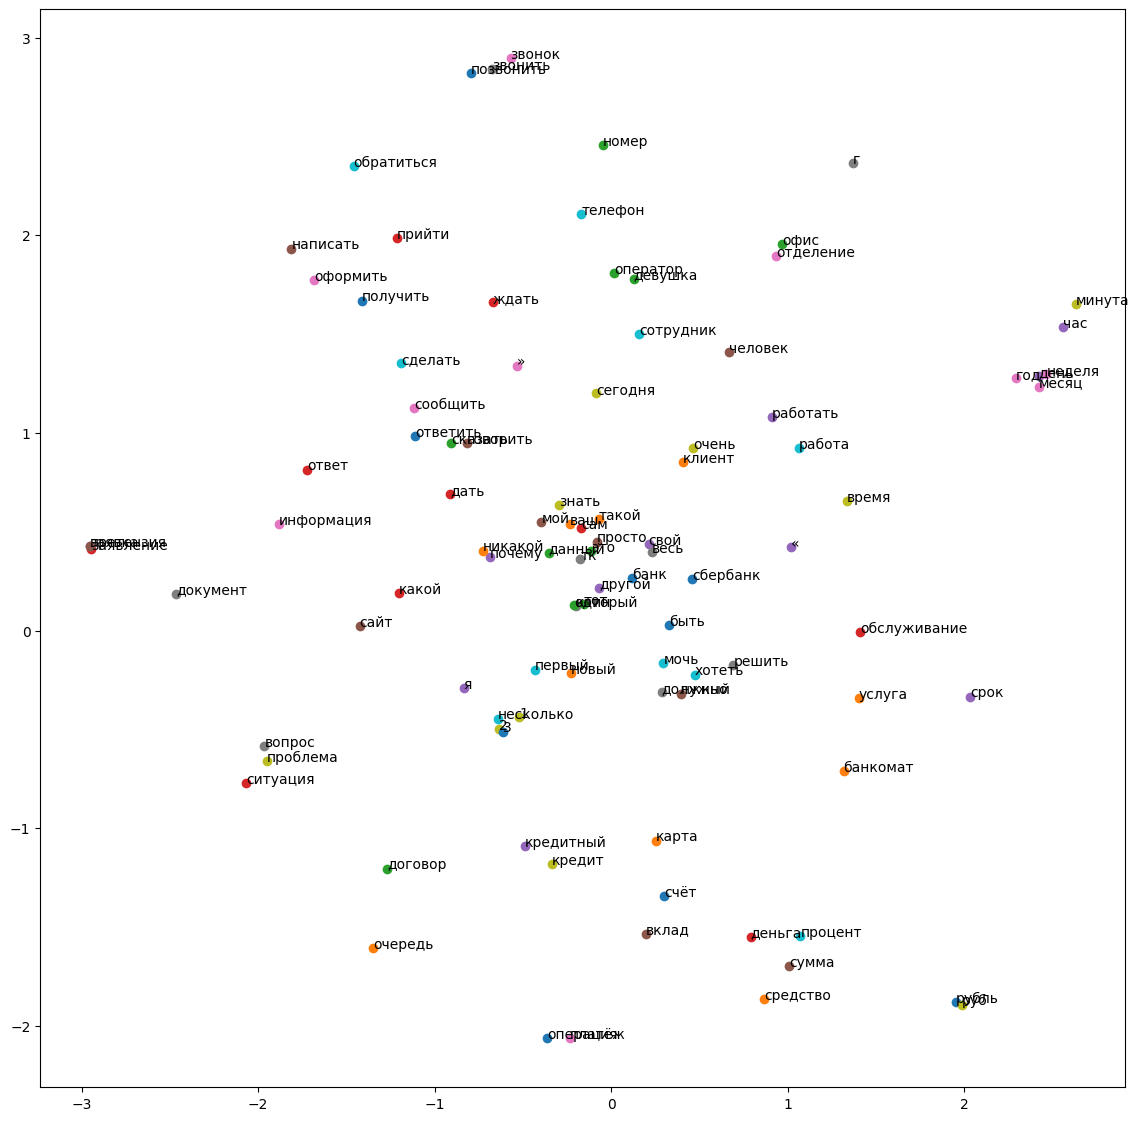

In [27]:
top_words = model.wv.index_to_key[:100]

top_vectors = [model.wv[word] for word in top_words]
top_vectors = np.array(top_vectors)

tsne = TSNE(n_components=2, perplexity=50, n_iter=3000, random_state=42)
word_vectors_2d = tsne.fit_transform(top_vectors)

plt.figure(figsize=(14, 14))
for i, word in enumerate(word_vectors_2d):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(top_words[i], (word_vectors_2d[i, 0], word_vectors_2d[i, 1]))
plt.show()

In [28]:
kmeans = KMeans(n_clusters=8, random_state=42) # Экспериментируйте с количеством кластеров
kmeans_labels = kmeans.fit_predict(word_vectors_2d)

c:\Users\Руслан\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [29]:
kmeans_labels

array([7, 5, 7, 4, 2, 7, 6, 7, 5, 6, 5, 6, 7, 3, 7, 4, 2, 3, 0, 0, 1, 7,
       6, 3, 5, 5, 5, 1, 6, 1, 1, 0, 5, 7, 6, 1, 2, 3, 3, 6, 0, 7, 1, 1,
       0, 7, 1, 0, 5, 0, 4, 4, 7, 3, 7, 6, 1, 0, 2, 1, 0, 5, 7, 0, 0, 7,
       3, 3, 7, 1, 5, 0, 6, 1, 7, 3, 2, 6, 6, 7, 5, 7, 7, 7, 2, 3, 1, 7,
       5, 4, 1, 7, 6, 7, 7, 0, 1, 7, 4, 5])

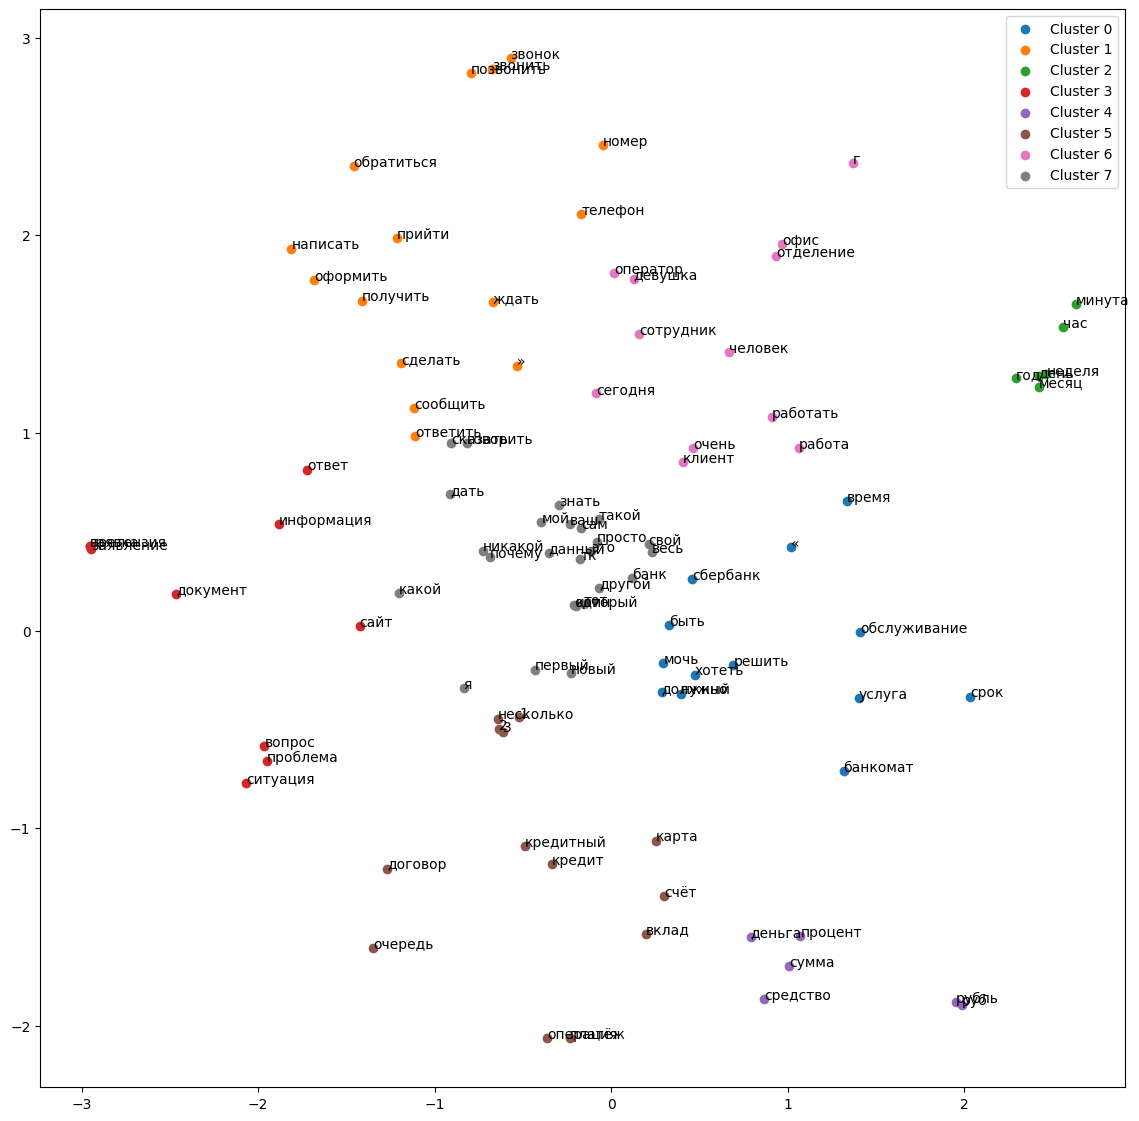

In [30]:
unique_labels = np.unique(kmeans_labels)

plt.figure(figsize=(14, 14))
for label in unique_labels:
    indices = np.where(kmeans_labels == label)[0]
    x_coords = word_vectors_2d[indices, 0]
    y_coords = word_vectors_2d[indices, 1]
    words = [top_words[i] for i in indices]
    plt.scatter(x_coords, y_coords, label=f'Cluster {label}')
    for i, word in enumerate(words):
        plt.annotate(word, (x_coords[i], y_coords[i]))


plt.legend() # добавить легенду
plt.show()

* Кластер 0 - услуга/решение проблемы
* Кластер 1 - частые глаголы, фигурирующие в банковском деле
* Кластер 2 - время
* Кластер 3 - информация/проблема
* Кластер 4 - связанно с деньгами
* Кластер 5 - связанно со счётом в банке
* Кластер 6 - часто фигурирующие слова, не привязанные к категории
* Кластер 7 - часто фигурирующие слова, не привязанные к категории

#### "Хорошесть" и "скорость" банков

In [31]:
model.wv.most_similar("банк", topn=30) # для выбора банков

[('сбербанк', 0.6840847134590149),
 ('ситибанк', 0.6732875108718872),
 ('альфабанка', 0.6326536536216736),
 ('росбанк', 0.6246004104614258),
 ('сбер', 0.5960267782211304),
 ('также', 0.582491934299469),
 ('компания', 0.5608768463134766),
 ('ваш', 0.5546275973320007),
 ('хотя', 0.552590548992157),
 ('который', 0.5507922768592834),
 ('организация', 0.5338826775550842),
 ('свой', 0.5267523527145386),
 ('именно', 0.523812472820282),
 ('мкб', 0.5236334204673767),
 ('действительно', 0.5231325030326843),
 ('альф', 0.5210378170013428),
 ('райффайзенбанк', 0.5192226767539978),
 ('поскольку', 0.5114973783493042),
 ('мочь', 0.5025551319122314),
 ('поэтому', 0.497526615858078),
 ('втб24', 0.4969906210899353),
 ('клиент', 0.4948118031024933),
 ('альфабанк', 0.4936223328113556),
 ('один', 0.48117148876190186),
 ('тк', 0.4788951873779297),
 ('сб', 0.4721773862838745),
 ('данный', 0.4620908498764038),
 ('промсвязьбанк', 0.46144676208496094),
 ('сити', 0.46008798480033875),
 ('аба', 0.45592546463012695

In [32]:
def get_coordinates(word, model=model):
    good_bad_vector = model.wv["хороший"] - model.wv["плохой"]
    fast_slow_vector = model.wv["быстрый"] - model.wv["медленный"]

    word_vector = model.wv[word]
    coordinate_1 = np.dot(word_vector, good_bad_vector)
    coordinate_2 = np.dot(word_vector, fast_slow_vector)

    return np.array([coordinate_1, coordinate_2])

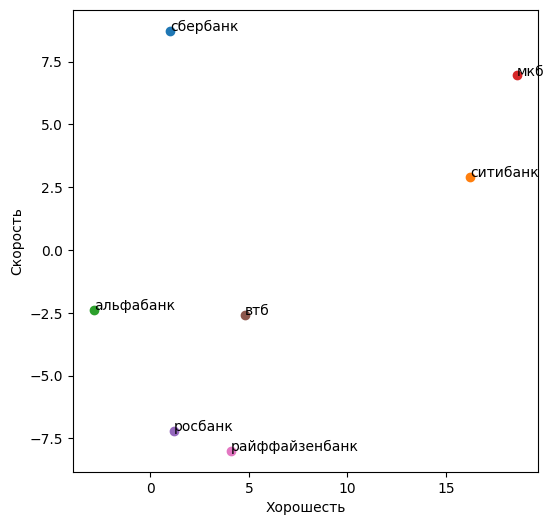

In [33]:
banks = ["сбербанк", "ситибанк", "альфабанк", "мкб", "росбанк", "втб", "райффайзенбанк"]

plt.figure(figsize=(6, 6))
for i, bank in enumerate(banks):
    coordinates = get_coordinates(bank)
    plt.scatter(coordinates[0], coordinates[1])
    plt.annotate(bank, (coordinates[0], coordinates[1]))
plt.xlabel("Хорошесть")
plt.ylabel("Скорость")
plt.show()

Видим, что по показателем "скорости" и "хорошести" лучшим оказался <b>МКБ</b>, худшими - <b>Росбанк</b> и <b>Альфа Банк</b>

## Распространение меток

In [183]:
positive_words = ["быстрый", "удобный", "хороший", "современный", "выгодный", "доступный"]
negative_words = ["медленный", "очередь", "ужасный", "долгий", "плохой", "непонятный"]

In [ ]:
import numpy as np
from sklearn.semi_supervised import LabelSpreading

word_vectors = np.array([model.wv[word] for word in model.wv.index_to_key])

labels = np.zeros(len(model.wv))


positive_indexes = [model.wv.key_to_index[word] for word in positive_words]
negative_indexes = [model.wv.key_to_index[word] for word in negative_words]

labels[positive_indexes] = 2
labels[negative_indexes] = 1

mask = labels != 0
X_train = word_vectors[mask]
y_train = labels[mask]


X_unlabeled = word_vectors[~mask]

lp_model = LabelSpreading(kernel="knn", n_neighbors=5)

lp_model.fit(X_train, y_train)

predicted_labels = lp_model.predict(word_vectors)


result = {word: label for word, label in zip(model.wv.index_to_key, predicted_labels)}

positive_new = [word for word, label in result.items() if label == 2]
negative_new = [word for word, label in result.items() if label == 1]

print("Новые позитивные слова:", positive_new)
print("Новые негативные слова:", negative_new)

Новые позитивные слова: ['карта', 'кредит', 'счёт', 'заявление', 'сумма', 'вопрос', 'мочь', 'получить', 'кредитный', 'вклад', 'платёж', 'дать', 'прийти', 'рубль', 'средство', 'сделать', 'информация', 'обратиться', 'операция', 'почему', '1', 'процент', 'ответить', 'нужно', 'оформить', 'руб', 'перевод', 'комиссия', 'смс', 'выдать', 'условие', 'момент', 'также', 'касса', 'смочь', 'предложить', 'нужный', 'система', 'попросить', 'погашение', 'денежный', 'оплата', 'снять', '000', 'получение', 'получать', 'поддержка', 'отправить', 'внести', 'карточка', 'хороший', 'просьба', 'банковский', 'лимит', 'возможность', 'быстро', 'любой', 'страховка', 'выписка', 'интернет', 'число', 'пора', 'ставка', 'перевести', 'почта', 'дебетовый', 'положить', 'покупка', 'прислать', 'дополнительный', 'заполнить', 'выдача', 'наличный', 'снятие', 'сообщение', 'близкий', 'предложение', 'возврат', 'тариф', 'депозит', 'чек', 'остаток', 'необходимо', 'зайти', 'необходимый', 'одобрить', 'запрос', 'больший', 'квартира', 'п

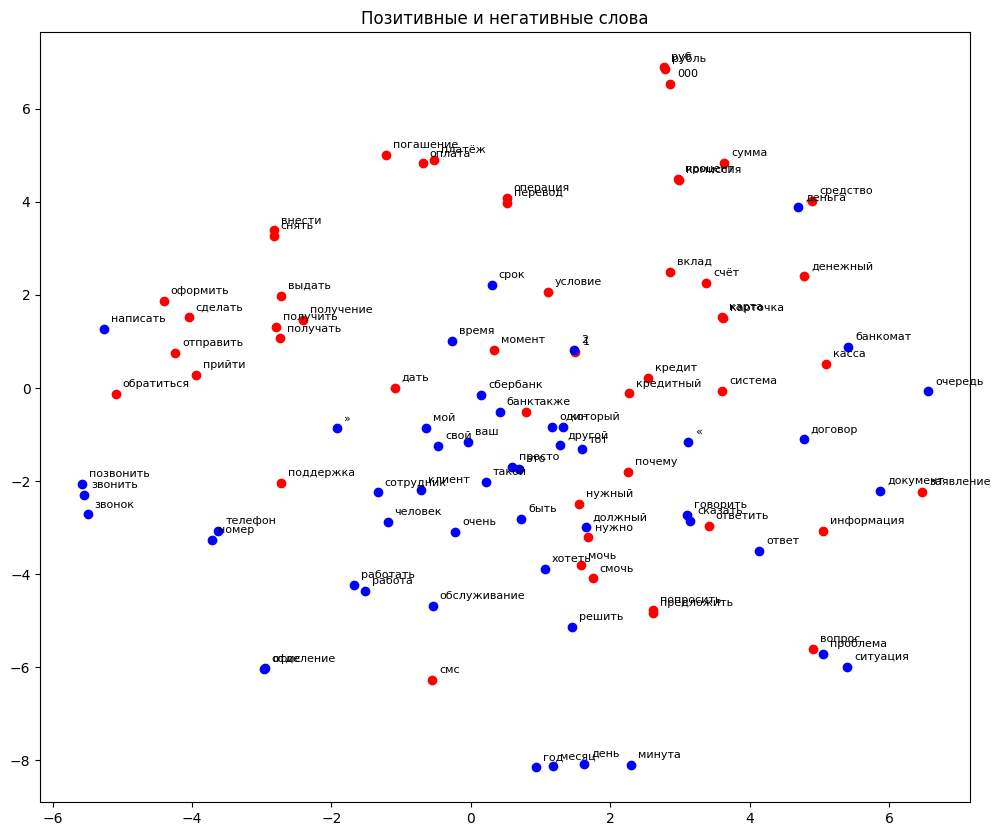

In [198]:
import random


def visualize_embeddings(embeddings, labels, words, num_words=50):

    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    positive_indices = np.where(labels == 2)[0]
    negative_indices = np.where(labels == 1)[0]

    positive_sample = random.sample(list(positive_indices), min(num_words, len(positive_indices)))
    negative_sample = random.sample(list(negative_indices), min(num_words, len(negative_indices)))
    all_indices = positive_sample + negative_sample

    plt.figure(figsize=(12, 10))
    for i in all_indices:
        x, y = embeddings_2d[i, 0], embeddings_2d[i, 1]
        plt.scatter(x, y, c=['red' if labels[i] == 2 else 'blue'][0])
        plt.annotate(words[i], (x, y), fontsize=8, textcoords="offset points", xytext=(5, 5), ha='left')

    plt.title('Позитивные и негативные слова')
    plt.show()

positive_indices = np.where(predicted_labels == 2)[0]
negative_indices = np.where(predicted_labels == 1)[0]

positive_embeddings = word_vectors[positive_indices][:min(50, len(positive_indices))]
positive_words_subset = [model.wv.index_to_key[i] for i in positive_indices][:min(50, len(positive_indices))]

negative_embeddings = word_vectors[negative_indices][:min(50, len(negative_indices))]
negative_words_subset = [model.wv.index_to_key[i] for i in negative_indices][:min(50, len(negative_indices))]

all_embeddings = np.concatenate((positive_embeddings,negative_embeddings))
all_labels = np.concatenate((np.full(len(positive_embeddings),2), np.full(len(negative_embeddings),1)))
all_words = positive_words_subset + negative_words_subset

visualize_embeddings(all_embeddings, all_labels, all_words)